# Catch me if you can(Alice)

[Original data](https://www.kaggle.com/competitions/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2)

Web-user identification is a hot research topic on the brink of sequential pattern mining and behavioral psychology.

Here we try to identify a user on the Internet tracking his/her sequence of attended Web pages. The algorithm to be built will take a webpage session (a sequence of webpages attended consequently by the same person) and predict whether it belongs to Alice or somebody else.

The train set `train_sessions.csv` contains information on user browsing sessions where the features are:

- `site_i` – are ids of sites in this session. The mapping is given with a pickled dictionary `site_dic.pkl`
- `time_j` – are timestamps of attending the corresponding site
- `target` – whether this session belongs to Alice

The task is to make predictions for sessions in the test sample `test_sessions.csv`, determine whether they belong to Alice.

**target metric** - `ROC AUC`

In [347]:
import datetime
import os
import pickle
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

%matplotlib inline
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import (GridSearchCV, StratifiedKFold,
                                     train_test_split)
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings("ignore")

### Download data

In [348]:
PATH_TO_DATA = "../data/raw"
times = ["time%d" % i for i in range(1, 11)]
sites = ["site%d" % i for i in range(1, 11)]

In [349]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, "train_sessions.csv"),
                       index_col="session_id",
                       parse_dates=times)

In [350]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [351]:
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, "test_sessions.csv"),
                      index_col="session_id",
                      parse_dates=times)

In [352]:
test_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,2014-10-04 11:19:54,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,2014-07-03 11:01:09,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53
3,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,2014-12-05 15:56:16,55.0,2014-12-05 15:56:17,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36
4,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,2014-11-04 10:03:21,3374.0,2014-11-04 10:03:22,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23
5,301,2014-05-16 15:05:31,301.0,2014-05-16 15:05:32,301.0,2014-05-16 15:05:33,66.0,2014-05-16 15:05:39,67.0,2014-05-16 15:05:40,69.0,2014-05-16 15:05:40,70.0,2014-05-16 15:05:40,68.0,2014-05-16 15:05:40,71.0,2014-05-16 15:05:40,167.0,2014-05-16 15:05:44


In [353]:
train_df.shape, test_df.shape

((253561, 21), (82797, 20))

In [354]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   site1   253561 non-null  int64         
 1   time1   253561 non-null  datetime64[ns]
 2   site2   250098 non-null  float64       
 3   time2   250098 non-null  datetime64[ns]
 4   site3   246919 non-null  float64       
 5   time3   246919 non-null  datetime64[ns]
 6   site4   244321 non-null  float64       
 7   time4   244321 non-null  datetime64[ns]
 8   site5   241829 non-null  float64       
 9   time5   241829 non-null  datetime64[ns]
 10  site6   239495 non-null  float64       
 11  time6   239495 non-null  datetime64[ns]
 12  site7   237297 non-null  float64       
 13  time7   237297 non-null  datetime64[ns]
 14  site8   235224 non-null  float64       
 15  time8   235224 non-null  datetime64[ns]
 16  site9   233084 non-null  float64       
 17  time9   233084 non-null  date

# Exploration Data Analysis

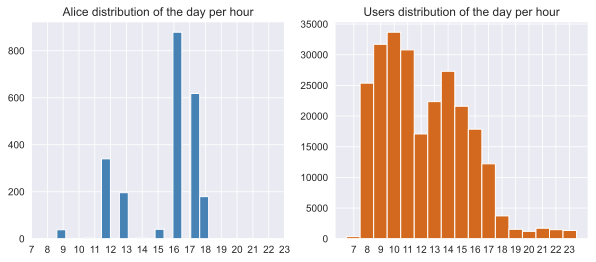

In [355]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
ax[0].hist(train_df[train_df.target == 1].time1.dt.hour, bins=17, color='steelblue', label='Alice')
ax[1].hist(train_df[train_df.target == 0].time1.dt.hour, bins=17, color='chocolate', label='Users')

for a in ax:
    a.set_xticks(ticks=[i + 0.5 for i in np.linspace(7, 22, 17)])
    a.set_xticklabels(labels=range(7, 24))

ax[0].title.set_text('Alice distribution of the day per hour')
ax[1].title.set_text('Users distribution of the day per hour')

plt.show()

Alice appears on the Internet less than all users. The peaks don't match. Time in day will be considered as feature.

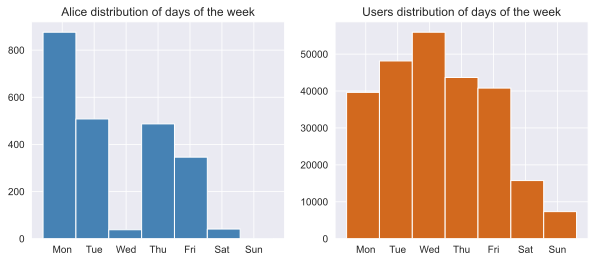

In [356]:
fig, ax = plt.subplots(ncols=2, figsize=((10, 4)))
ax[0].hist(train_df[train_df.target == 1].time1.dt.dayofweek, bins=7, color='steelblue', label='Alice')
ax[1].hist(train_df[train_df.target == 0].time1.dt.dayofweek, bins=7, color='chocolate', label='Users')

for a in ax:
    a.set_xticks(ticks=[i - 0.5 for i in np.linspace(1, 6, 7)])
    a.set_xticklabels(labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

ax[0].title.set_text('Alice distribution of days of the week')
ax[1].title.set_text('Users distribution of days of the week')
plt.show()

The distributions of days are really different. We observe the periods when Alice doesn't use the internet at all.

In [357]:
# let's look at the day of the week and Alice time
pd.crosstab(train_df[train_df.target == 1].time1.dt.day_of_week,
            train_df[train_df.target == 1].time1.dt.hour)

time1,9,11,12,13,14,15,16,17,18
time1,,,,,,,,,
0,0,0,0,0,0,9,445,311,111
1,0,1,107,36,1,3,152,169,39
2,0,0,0,0,0,6,6,16,10
3,0,0,57,32,0,22,276,87,13
4,38,1,176,128,3,0,0,0,0
5,0,0,0,0,0,0,0,35,6
6,0,1,0,0,0,0,0,0,0


In [358]:
# we will find the hours when Alice was on the Internet only on 1-2 particular dates
for h in np.unique(train_df[train_df.target == 1].time1.dt.hour):
    days = train_df[train_df.target == 1][train_df[train_df.target == 1].time1.dt.hour == h].time1.dt.date.value_counts()
    if len(days) <= 2:
        print(h, days.index.values)

9 [datetime.date(2013, 4, 12)]
14 [datetime.date(2013, 11, 15) datetime.date(2014, 1, 28)]


At 9 o'clock Alice was active only for one day, and there were a lot of sessions on that day. This is atypical behavior and these sessions should be removed from training.

In [359]:
# let's look at the day of the week and users time
pd.crosstab(train_df[train_df.target == 0].time1.dt.day_of_week,
            train_df[train_df.target == 0].time1.dt.hour)

time1,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
time1,,,,,,,,,,,,,,,,,
0,43,3671,4472,5012,5317,2055,4108,4145,3528,3478,2091,540,328,227,298,183,141
1,72,5599,6456,6576,5220,3014,3651,6137,4180,3121,2603,636,240,136,126,195,189
2,72,6538,8520,7479,7672,4260,4245,4959,4841,4191,2052,559,81,74,147,118,125
3,63,4356,4956,4917,4823,3113,4679,5725,3756,3186,2472,782,287,112,161,125,147
4,55,2899,4306,7087,5412,3551,4086,4006,3472,2512,1832,558,209,210,245,231,123
5,26,1965,2626,2191,1910,583,766,1241,981,758,644,364,169,272,466,367,429
6,10,341,367,414,441,504,821,1089,842,614,518,280,226,169,262,248,185


users are online more evenly

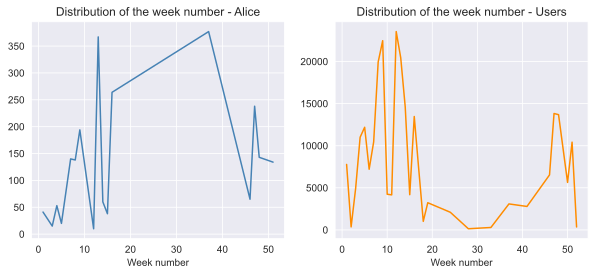

In [360]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
ax[0].plot(train_df[train_df.target == 1].time1.dt.week.value_counts().sort_index(), color='steelblue', label="Alice")
ax[1].plot(train_df[train_df.target == 0].time1.dt.week.value_counts().sort_index(), color="darkorange", label="Users")

for a in ax:
    a.set_xlabel("Week number")
    
ax[0].title.set_text('Distribution of the week number - Alice')
ax[1].title.set_text('Distribution of the week number - Users')
plt.show()

The distribution by week looks very different.

In [361]:
train_df[train_df.target == 1].time1.dt.week.value_counts().sort_index()

1      41
3      15
4      53
5      20
7     140
8     138
9     194
12     10
13    367
14     60
15     38
16    264
37    377
46     65
47    238
48    143
51    134
Name: time1, dtype: int64

There are breaks in weeks: 2, 6, 49, 50.

In [362]:
test_df.time1.dt.week.value_counts().sort_index()

18    10048
19      304
20     7228
21     5606
22     4021
23     2838
27    10837
31     3729
32     4117
36     3627
40     8157
44     6378
45     3519
49    12388
Name: time1, dtype: int64

it is necessary to supplement the training data with week 49.

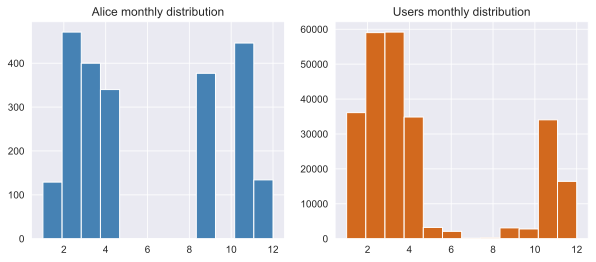

In [363]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
ax[0].hist(train_df[train_df.target == 1].time1.dt.month, bins=12, color='steelblue', label='Alice')
ax[1].hist(train_df[train_df.target == 0].time1.dt.month, bins=12, color='chocolate', label='Users')
ax[0].title.set_text('Alice monthly distribution')
ax[1].title.set_text('Users monthly distribution')
plt.show()

The distribution of months looks very intriguing. It's easy to hypothesize that Alice doesn't use the Internet in the summer. But most of the test set ends with summer sessions. So it is unlikely that we should predict "zero" for all these dates.

In [364]:
train_df[train_df.target == 1].time1.dt.month.value_counts().sort_index()

1     129
2     471
3     400
4     340
9     377
11    446
12    134
Name: time1, dtype: int64

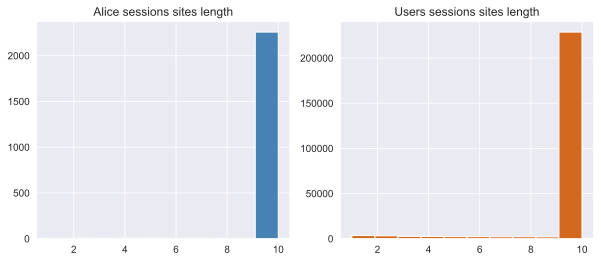

In [365]:
count_sites_alice = len(sites) - np.sum(train_df[train_df.target == 1][sites].isna(), axis=1)
count_sites_users = len(sites) - np.sum(train_df[train_df.target == 0][sites].isna(), axis=1)

fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
ax[0].hist(count_sites_alice, bins=10, color='steelblue', label='Alice')
ax[1].hist(count_sites_users, bins=10, color='chocolate', label='Users')
ax[0].title.set_text('Alice sessions sites length')
ax[1].title.set_text('Users sessions sites length')
plt.show()

Basically sessions have a length of 10. It is necessary to look separately at sessions of length less than 10:

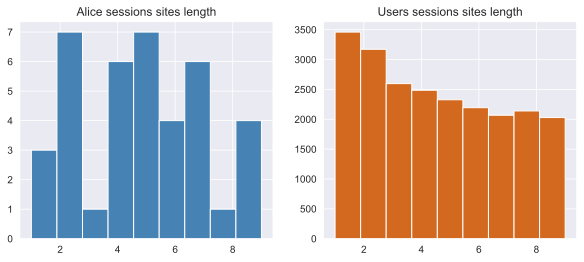

In [366]:
count_sites_alice_short = count_sites_alice[count_sites_alice != 10]
count_sites_users_short = count_sites_users[count_sites_users != 10]

fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
ax[0].hist(count_sites_alice_short, bins=9, color='steelblue', label='Alice')
ax[1].hist(count_sites_users_short, bins=9, color='chocolate', label='Users')
ax[0].title.set_text('Alice sessions sites length')
ax[1].title.set_text('Users sessions sites length')
plt.show()

There is a difference in some sessions. Maybe add it as a categorical feature.

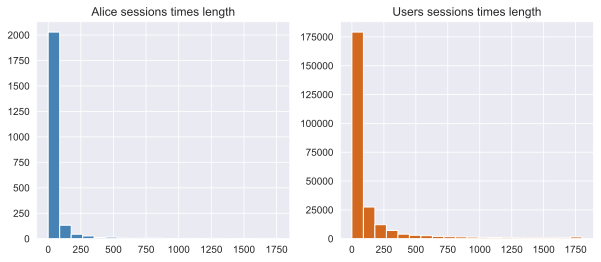

In [367]:
sessions_times_alice = (np.max(train_df[train_df.target == 1][times], axis=1) \
                      - np.min(train_df[train_df.target == 1][times], axis=1)).dt.seconds

sessions_times_users = (np.max(train_df[train_df.target == 0][times], axis=1) \
                      - np.min(train_df[train_df.target == 0][times], axis=1)).dt.seconds
                      
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
ax[0].hist(sessions_times_alice, bins=20, color='steelblue', label='Alice')
ax[1].hist(sessions_times_users, bins=20, color='chocolate', label='Users')
ax[0].title.set_text('Alice sessions times length')
ax[1].title.set_text('Users sessions times length')
plt.show()

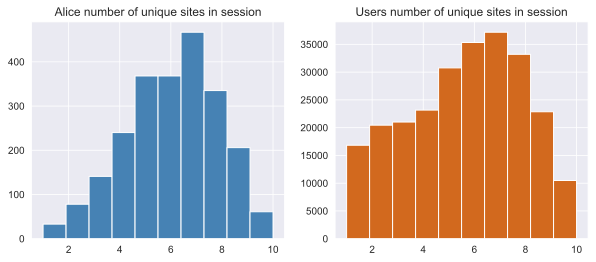

In [368]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
ax[0].hist(train_df[train_df.target == 1][sites].nunique(axis=1), bins=10, color='steelblue', label='Alice')
ax[1].hist(train_df[train_df.target == 0][sites].nunique(axis=1), bins=10, color='chocolate', label='Users')
ax[0].title.set_text('Alice number of unique sites in session')
ax[1].title.set_text('Users number of unique sites in session')
plt.show()

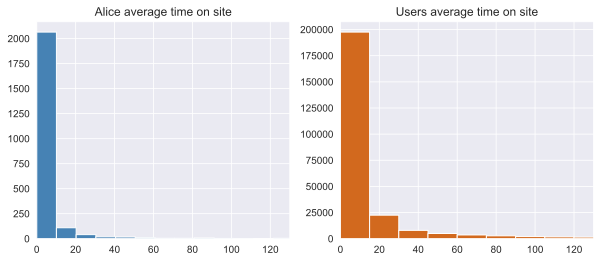

In [369]:
avgtime_sites_alice = sessions_times_alice / count_sites_alice
avgtime_sites_users = sessions_times_users / count_sites_users

fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
ax[0].hist(avgtime_sites_alice, bins=40, color='steelblue', label='Alice')
ax[1].hist(avgtime_sites_users, bins=60, color='chocolate', label='Users')
ax[0].title.set_text('Alice average time on site')
ax[1].title.set_text('Users average time on site')
for a in ax:
    a.set_xlim([0, 130])
plt.show()

we can find differences on the sites visited:

In [370]:
# load sites dictionary
with open(os.path.join(PATH_TO_DATA, "site_dic.pkl"), "rb") as dict_with_sites:
    dict_sites = pickle.load(dict_with_sites)

In [371]:
print(*list(dict_sites.items())[:15], sep='\n')

('www.abmecatronique.com', 25075)
('groups.live.com', 13997)
('majeureliguefootball.wordpress.com', 42436)
('cdt46.media.tourinsoft.eu', 30911)
('www.hdwallpapers.eu', 8104)
('img378.imageshack.us', 37491)
('ecologie.nature.free.fr', 5462)
('www.ibcn.intec.ugent.be', 35425)
('kissanime.com', 30151)
('www.carolineconduiteformation.com', 38268)
('images.mystockphoto.com', 43641)
('journalph.csphares.qc.ca', 36959)
('www.uqo.ca', 40935)
('d8d94e0wul1nb.cloudfront.net', 12346)
('openapi.elong.com', 31023)


In [372]:
dict_sites_reverse = {name: site for (site, name) in dict_sites.items()}

In [373]:
alice_sites = (train_df[train_df.target == 1][sites]
                .applymap(dict_sites_reverse.get)
                .melt()
                .value.value_counts())

alice_sites.to_csv("alice_sites.csv")
alice_sites.head(20)

i1.ytimg.com                            1382
s.youtube.com                           1354
www.youtube.com                         1307
www.facebook.com                         897
www.google.fr                            857
r4---sn-gxo5uxg-jqbe.googlevideo.com     609
r1---sn-gxo5uxg-jqbe.googlevideo.com     522
apis.google.com                          522
s.ytimg.com                              451
r2---sn-gxo5uxg-jqbe.googlevideo.com     447
www.google.com                           437
s-static.ak.facebook.com                 381
r3---sn-gxo5uxg-jqbe.googlevideo.com     371
twitter.com                              293
static.ak.facebook.com                   291
vk.com                                   286
translate.google.fr                      274
platform.twitter.com                     272
yt3.ggpht.com                            236
mts0.google.com                          215
Name: value, dtype: int64

Apparently, Alice likes to watch video content. we select everything related to video and audio - 

`cinema`, `film`, `media`, `movie`, `mtv`, `music`, `radio`, `stream`, `tv`, `video`, `yt3`, `youwatch`, `ytimg`, `youtube`

let's see which sites users visit:

In [374]:
users_sites = (train_df[train_df.target == 0][sites]
                .applymap(dict_sites_reverse.get)
                .melt()
                .value.value_counts())

users_sites.to_csv("users_sites.csv")
users_sites.head(10)

www.google.fr             122919
www.google.com             87182
annotathon.org             77055
apis.google.com            57736
www.facebook.com           53197
www.bing.com               46355
blast.ncbi.nlm.nih.gov     43841
www.ncbi.nlm.nih.gov       38194
clients1.google.com        35879
mail.google.com            35178
Name: value, dtype: int64

how many top sites cover the total number of sites?

In [375]:
top_head = 200
alice_sites_rolling = (alice_sites.head(top_head).rolling(window=top_head, min_periods=1).sum() / alice_sites.sum())

for i in range(19, top_head, 20):
    print("top-{0} sites cover {1} all sites".format(i + 1, alice_sites_rolling[i]))

top-20 sites cover 0.5008564275989283 all sites
top-40 sites cover 0.6306820677236593 all sites
top-60 sites cover 0.6996793886424525 all sites
top-80 sites cover 0.7449602529755369 all sites
top-100 sites cover 0.7759234046291009 all sites
top-120 sites cover 0.8004304097676666 all sites
top-140 sites cover 0.8211603495981378 all sites
top-160 sites cover 0.8390355307655145 all sites
top-180 sites cover 0.8531775659888445 all sites
top-200 sites cover 0.8650357942816989 all sites


In [376]:
top_head = 400
users_sites_rolling = (users_sites.head(top_head).rolling(window=top_head, min_periods=1).sum() / users_sites.sum())

for i in range(19, top_head, 20):
    print("top-{0} sites cover {1} all sites".format(i + 1, users_sites_rolling[i]))

top-20 sites cover 0.3522568617106068 all sites
top-40 sites cover 0.4554508137906566 all sites
top-60 sites cover 0.5179972812978142 all sites
top-80 sites cover 0.5592510138650464 all sites
top-100 sites cover 0.5899495881153637 all sites
top-120 sites cover 0.6135669012861745 all sites
top-140 sites cover 0.6319074720797486 all sites
top-160 sites cover 0.6470686926255727 all sites
top-180 sites cover 0.6605304105123151 all sites
top-200 sites cover 0.6726382163840926 all sites
top-220 sites cover 0.6834389699892599 all sites
top-240 sites cover 0.6933606849221647 all sites
top-260 sites cover 0.7022732417030004 all sites
top-280 sites cover 0.7103293529045304 all sites
top-300 sites cover 0.7178089218450524 all sites
top-320 sites cover 0.7247926979123563 all sites
top-340 sites cover 0.7313610121036219 all sites
top-360 sites cover 0.7374624023737809 all sites
top-380 sites cover 0.7431613008768212 all sites
top-400 sites cover 0.7484786271432582 all sites


# Feature Engineering 

The key idea here is to write your own classes for data transformation. They must follow a pretty simple template: they should inherit from two base classes – `BaseEstimator`, `TransformerMixin` – and have a `fit()` and `transform()` methods, which take the dataset (X) as input and have a y value set to None.

In [377]:
class DataPreparator(BaseEstimator, TransformerMixin):
    """
    Prepares CountVectorizer friendly list of strings with sites IDs
    """

    def __init__(self, sites):
        self.sites = sites
        super().__init__()

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X[self.sites].fillna(0).astype(int).values.tolist()
        return [" ".join(map(str, filter(lambda x: x != 0, row))) for row in X]

One of the great advantages of pipelines, is that you can use classes for adding features too. You can test new features quite easilly by adding/removing some of them from the class, and then just running the whole pipeline.

In [378]:
class PreferencesAttributesAdder(BaseEstimator, TransformerMixin):
    """
    Add topics of preferences from Alice and users
    """

    def __init__(self, sites, dict_sites):
        self.sites = sites
        self.dict_sites = dict_sites
        self.alice_sites = []
        self.users_sites = []
        super().__init__()

    def fit(self, X, y=None):
        alice_topics = {"cinema", "film", "media", "movie", "mtv", "music", "radio",
                        "stream", "tv", "video", "yt3", "youwatch", "ytimg", "youtube"}
        X = X[self.sites].applymap(self.dict_sites.get, na_action="ignore")
        # get the number of Alice sites and people users
        alice_sites_count = X[y == 1].melt().value.value_counts()
        users_sites_count = X[y == 0].melt().value.value_counts()
        # get the best different sites for Alice and users
        self.users_sites = set(users_sites_count.head(50).index).difference(alice_sites_count.index)
        alice_sites_set = set(alice_sites_count.head(40).index).difference(users_sites_count.head(250).index)

        self.alice_sites = alice_topics.union([site for site in alice_sites_set if all([at not in site for at in alice_topics])])

        return self

    def transform(self, X):
        X = X[self.sites].applymap(self.dict_sites.get, na_action="ignore")
        alice_preferences = X.apply(self.check_preference, axis=1, args=(self.alice_sites,))
        users_preferences = X.apply(self.check_preference, axis=1, args=(self.users_sites,))

        return np.c_[alice_preferences, users_preferences]

    def check_preference(self, row, list_of_preferences):
        for site in row:
            if isinstance(site, str):
                for preference in list_of_preferences:
                    if preference in site:
                        return 1
        return 0

In [379]:
class CategoricalAttributesAdder(BaseEstimator, TransformerMixin):
    """
    Add new categorical features
    """

    def __init__(self, sites, times):
        self.sites = sites
        self.times = times
        super().__init__()

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        dayofweek = X[self.times[0]].dt.dayofweek
        sites_count = len(self.sites) - np.sum(X[self.sites].isna(), axis=1)
        week = X[self.times[0]].dt.week
        
        return np.c_[dayofweek, sites_count, week]  

In [380]:
class NumericAttributesAdder(BaseEstimator, TransformerMixin):
    """
    Add new numeric features
    """

    def __init__(self, sites, times):
        self.sites = sites
        self.times = times
        self.alice_sites = []
        self.users_sites = []
        super().__init__()

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        sites_count = len(self.sites) - np.sum(X[self.sites].isna(), axis=1)
        # numeric_only=False is a workaround to make pd.Dataframe.sum() work w/ NaT values
        session_time = ((X[self.times].max(axis=1, numeric_only=False)
                       - X[self.times].min(axis=1, numeric_only=False)).dt.seconds) ** 0.1

        time_per_site = (session_time / sites_count) ** 0.1
        alice_time = X[self.times[0]].apply(self.check_alice_time)

        is_morning = (X[self.times[0]].dt.hour <= 11).astype(int)
        is_evening = (X[self.times[0]].dt.time > datetime.time(18, 30)).astype(int)

        return np.c_[session_time, time_per_site, alice_time, is_morning, is_evening]

    def check_alice_time(self, dt):
        """
        The method returns 1 if the time refers to Alice's standard working hours, otherwise - 0
        """
        timetable = [
            # Mon
            [(datetime.time(12, 0), datetime.time(13, 50)),
             (datetime.time(15, 50), datetime.time(18, 20))],
            # Tue
            [(datetime.time(12, 0), datetime.time(13, 50)),
             (datetime.time(15, 50), datetime.time(18, 20))],
            # Wed
            [(datetime.time(15, 50), datetime.time(18, 20))],
            # Thur
            [(datetime.time(12, 0), datetime.time(13, 50)),
             (datetime.time(15, 50), datetime.time(18, 20))],
            # Fri
            [(datetime.time(12, 0), datetime.time(13, 50)),
             (datetime.time(15, 50), datetime.time(18, 20))],
            # Sat
            [(datetime.time(12, 0), datetime.time(13, 50)),
             (datetime.time(15, 50), datetime.time(18, 20))],
            # Sun
            [(datetime.time(12, 0), datetime.time(13, 50)),
             (datetime.time(15, 50), datetime.time(18, 20))]]

        for start, end in timetable[dt.weekday()]:
            if dt.time() >= start and dt.time() <= end:
                return 1
        return 0

In [381]:
def remove_bad_data(train_data, times):
    """
    Removing bad data from the training df - 2013-4-12
    """
    return train_data[~((train_data.target == 1) & (train_data[times[0]].dt.date == datetime.date(2013, 4, 12)))]

In [382]:
def add_missing_data(train_data, times):
    """
    Merges data from week 48 to week 49 from the test dataset
    """
    merged_df = train_data[train_data[times[0]].dt.week == 48].copy()
    merged_df[times] = merged_df[times].applymap(lambda x: x + datetime.timedelta(days=7))
    
    return train_data.append(merged_df, ignore_index=True)

#### Pipelines for data transformation and building datasets:

Once we've written the classes, we want to combine them into a pipeline. The `Pipeline()` class will call `transform()` methods on each one of them and return the transformed dataset, which you can pass to another pipeline as many times as you want.

In [383]:
base_pipeline = Pipeline([
    ("preparator", DataPreparator(sites)),
    ("vectorizer", CountVectorizer(
        token_pattern=r"(?u)[1-9]\w*\b",
        ngram_range=(1, 1),
        max_features=50000)),
])

y_base = train_df.target
X_train_base_sparse = base_pipeline.fit_transform(train_df[train_df.columns[:-1]])
X_test_base_sparse = base_pipeline.transform(test_df)

train_share = int(0.7 * X_train_base_sparse.shape[0])
X_train_base, y_train_base = X_train_base_sparse[:train_share, :], y_base[:train_share]
X_valid_base, y_valid_base = X_train_base_sparse[train_share:, :], y_base[train_share:]

In [384]:
vectorizer_pipeline = Pipeline([
    ("preparator", DataPreparator(sites)),
    ("vectorizer", TfidfVectorizer(
        token_pattern=r"(?u)[1-9]\w*\b",
        ngram_range=(1, 3),
        max_features=50000,
        sublinear_tf=True)),
])

categorical_attributes_pipeline = Pipeline([
    ("adder", CategoricalAttributesAdder(sites, times)),
    ("encoder", OneHotEncoder(handle_unknown="ignore")),
])

numerical_attributes_pipeline = Pipeline([
    ("adder", NumericAttributesAdder(sites, times)),
    ("scaler", StandardScaler()),
])

preferences_attributes_pipeline = Pipeline([
    ("adder", PreferencesAttributesAdder(sites, dict_sites_reverse)),
    ("scaler", StandardScaler()),
])

Finally you can combine these pipelines using `FeatureUnion()` class, which will merge the resulting datasets from each pipeline:

In [385]:
train_df_cleared = remove_bad_data(train_df, times)
train_df_cleared = add_missing_data(train_df_cleared, times)
y = train_df_cleared.target

full_pipeline = FeatureUnion(transformer_list=[
    ("vectorizer_pipeline", vectorizer_pipeline),
    ("preferences_attributes_pipeline", preferences_attributes_pipeline),
    ("categorical_attributes_pipeline", categorical_attributes_pipeline),
    ("numerical_attributes_pipeline", numerical_attributes_pipeline),
])

In [386]:
%%time
X_train_sparse = full_pipeline.fit_transform(train_df_cleared[train_df_cleared.columns[:-1]], y)
X_test_sparse = full_pipeline.transform(test_df)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_sparse, y, test_size=0.2, stratify=y, random_state=21)

CPU times: total: 43.2 s
Wall time: 48.5 s


# Model Selection

In [387]:
def fit_score(classifier, X_train, y_train, X_valid, y_valid):
    """
    Calculate ROC-AUC on validation dataset
    """
    clf = classifier.fit(X_train, y_train)
    print(type(clf).__name__, "ROC-AUC = ", roc_auc_score(y_valid, clf.predict_proba(X_valid)[:, 1]))

In [388]:
def plot_cv_result(score, parameter_name, parameter_value, metric="ROC-AUC", allTicks=True):
    fig, ax = plt.subplots()
    if allTicks:
        ax.plot(score[0], label="Train")
        ax.plot(score[1], label="Test")
    else:
        ax.plot(parameter_value, score[0], label="Train")
        ax.plot(parameter_value, score[1], label="Test")

    ax.set_xlabel(parameter_name)
    ax.set_ylabel(metric)

    if allTicks:
        ax.set_xticks(range(0, len(parameter_value)))
        ax.set_xticklabels(np.round(parameter_value, 4))

    ax.legend()
    plt.show()

In [389]:
def optimize_parameters(classifier, parameter_name, parameter_values, X_train, y_train, X_valid, y_valid, cv=None, n_jobs=4):
    """
    Calculate CV scores on train and validation datasets
    """
    if cv is None:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)
    parameter_grid = {parameter_name: parameter_values}

    grid_search = GridSearchCV(classifier, parameter_grid, scoring=["roc_auc"], cv=cv, refit=False, return_train_score=True, n_jobs=4)
    grid_search = grid_search.fit(X_train, y_train)

    plot_cv_result((grid_search.cv_results_["mean_train_roc_auc"],
                    grid_search.cv_results_["mean_test_roc_auc"]),
                    parameter_name,
                    parameter_values)

    best_roc_auc = parameter_values[np.argmin(grid_search.cv_results_["rank_test_roc_auc"])]

    print(parameter_name, "=", best_roc_auc)

    return best_roc_auc, grid_search.cv_results_

In [390]:
def write_to_submission_file(pred_labels, output, target="target", index_label="session_id"):
    predicted_df = pd.DataFrame(pred_labels, index=np.arange(1, pred_labels.shape[0] + 1), columns=[target])
    predicted_df.to_csv(output, index_label=index_label)

## LogisticRegression (base)

In [391]:
lr_base_params = {"n_jobs": 4, "multi_class": "ovr","random_state": 21, "solver": "lbfgs"}
fit_score(LogisticRegression(**lr_base_params), X_train_base, y_train_base, X_valid_base, y_valid_base)

LogisticRegression ROC-AUC =  0.9583007642278456


## LogisticRegression (feature engineering)

In [392]:
lr_params = {"n_jobs": 4, "multi_class": "ovr", "random_state": 21, "solver": "lbfgs"}
lr_fe = LogisticRegression(**lr_params)
fit_score(lr_fe, X_train, y_train, X_valid, y_valid)

LogisticRegression ROC-AUC =  0.9903526463613318


In [393]:
lr_fe.fit(X_train_sparse, y)
lr_fe_predict = lr_fe.predict_proba(X_test_sparse)[:, 1]
write_to_submission_file(lr_fe_predict, "/submission.csv")

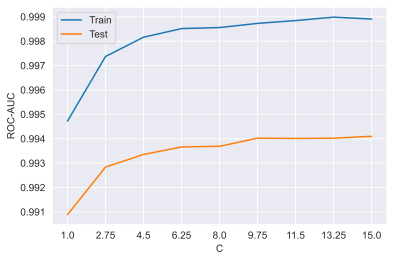

C = 15.0
CPU times: total: 1.31 s
Wall time: 2min 28s


In [394]:
%%time
c_value = np.linspace(1, 15, 9)
temp, temp1 = optimize_parameters(LogisticRegression(**lr_params), "C", c_value, X_train, y_train, X_valid, y_valid)

In [395]:
lr_params["C"] = 3.0
lr_opt = LogisticRegression(**lr_params)
fit_score(lr_opt, X_train, y_train, X_valid, y_valid)
lr_opt.fit(X_train_sparse, y)
lr_opt_predict = lr_opt.predict_proba(X_test_sparse)[:, 1]
write_to_submission_file(lr_opt_predict, "/submission.csv")

LogisticRegression ROC-AUC =  0.9925809335547546


The main contribution to the improvement of the result was made by the addition of new features. By removing Alice's atypical behavior from the training sample and filling in the missing values with known data, the score was improved